## SPHEREx power spectrum 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u 
import astropy.constants as cu 
import oLIMpus.analysis as a 
from oLIMpus import eor_colour, LIM_colour_1
from oLIMpus import CoevalBox_LIM_analytical
from oLIMpus import SFR_II, rhoL_integrand
import powerbox as pb
from scipy.interpolate import RegularGridInterpolator, interp1d

Set parameters for the run.

In [2]:
# set user parameters, see inputs.py for details
UP = a.User_Parameters(
            precisionboost= 1.0, 
            FLAG_FORCE_LINEAR_CF= 0, 
            MIN_R_NONLINEAR= 1, 
            MAX_R_NONLINEAR= 200.0,
            FLAG_DO_DENS_NL= False, 
            FLAG_WF_ITERATIVE= True,
            )

CosmoParams_input_fid = dict(
        omegab= 0.048*0.678**2, 
        omegac = (0.307 - 0.048)*0.678**2, 
        h_fid = 0.678, 
        As = 2.100549e-09, 
        ns = 0.9660499, 
        tau_fid = 0.05430842, 
        HMF_CHOICE= "ST",
        Flag_emulate_21cmfast = False,
        zmin_CLASS = 0.,
        _Mhmin = 1e5,
        _Mhmax = 1e14
        )

CosmoParams_input_SAM = dict(
        omegab= 0.048*0.678**2, 
        omegac = (0.307 - 0.048)*0.678**2, 
        h_fid = 0.678, 
        As = 2.100549e-09, 
        ns = 0.9660499, 
        tau_fid = 0.05430842, 
        HMF_CHOICE= "ST",
        Flag_emulate_21cmfast = False,
        zmin_CLASS = 0.,
        _Mhmin = 1e10,
        _Mhmax = 1e14
        )


# set fiducial cosmology, run CLASS and get the halo mass function
CP_fid, ClassyC_fid, zeus_corr_fid, HMFcl_fid = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**CosmoParams_input_fid))
CP_SAM, ClassyC_SAM, zeus_corr_SAM, HMFcl_SAM = a.cosmo_wrapper(UP, a.Cosmo_Parameters_Input(**CosmoParams_input_SAM))

In [3]:
set_scatter = 0.2

SFR parameters, by default we use GALLUMI (see sfrd.py for details)

In [4]:
AstroParams_input_fid = dict(

        astromodel = 0,
        accretion_model = 0,
        alphastar =  1.246,
        betastar = -1.522,
        epsstar = 0.395,
        Mc = 5.786e11,
        Mturn_fixed = None,
        dlog10epsstardz = 0.0,
        quadratic_SFRD_lognormal = True,
         
        fesc10 = 0.1,
        alphaesc = 0.,
        L40_xray = 3.0,
        E0_xray = 500.,
        alpha_xray = -1.0,
        Emax_xray_norm=2000,

        Nalpha_lyA_II = 9690,
        Nalpha_lyA_III = 17900,

        FLAG_MTURN_SHARP= False,

        C0dust = 4.43,
        C1dust = 1.99,
        sigmaUV=0.5,

        USE_POPIII = False,
        alphastar_III = 0, 
        betastar_III = 0,
        fstar_III = 10**(-2.5),
        Mc_III = 1e7,
        dlog10epsstardz_III = 0.0,
        fesc7_III = 10**(-1.35),
        alphaesc_III = -0.3,
        L40_xray_III = 3.0,
        alpha_xray_III = -1.0,        
        USE_LW_FEEDBACK = False,
        A_LW = 2.0,
        beta_LW = 0.6,
        A_vcb = 1.0,
        beta_vcb = 1.8,
        )

AP_fid = a.zeus21.Astro_Parameters(UP, CP_fid, **AstroParams_input_fid)


The following are the default parameters to run OIII.
In particular note that
- LINE : you can choose 'OIII4960' or 'OIII5007'
- LINE_MODEL : you can choose between 'Yang24' and 'THESAN'; see LIM_luminosities.py for details
- _R : down to which scale the power spectrum is computed, >= 1 Mpc to trust the modeling
- sigma_LMh : scattering in the line-Mh or line-SFR relations, see LIM_modeling.py; 
- line_dict : if None, it uses the default parameters defined at the bottom of LIM_luminosities.py

In [5]:
# set line parameters
LineParams_SFR_scatter = a.LineParams_Input(
            LINE = 'SFRD', # which line
            LINE_MODEL = 'powerlaw', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in uK (Tnu)
            _R = 1., # resolution for smoothing (Mpc)
            stoch_type='median',
            sigma_LMh = set_scatter*u.dex, # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
            line_dict = {'alpha_SFR':1.},
        )

LP_SFR_scatter = a.Line_Parameters(LineParams_SFR_scatter,UP)


LineParams_SFR = a.LineParams_Input(
            LINE = 'SFRD', # which line
            LINE_MODEL = 'powerlaw', # model of the line luminosity
            OBSERVABLE_LIM = 'Inu', # observe intensity in uK (Tnu)
            _R = 1., # resolution for smoothing (Mpc)
            stoch_type='median',
            sigma_LMh = 0.*u.dex, # stochasticity in the L-SFR relation
            shot_noise = True, # add shot noise to the power spectrum
            quadratic_lognormal = True, # use 1st or 2nd order in the SFRD and line lognormal approximation MOVE TO USER PARAMS
            line_dict = {'alpha_SFR':1.}
        )

LP_SFR = a.Line_Parameters(LineParams_SFR,UP)


You introduced stochasticity: be sure that sigma_LMh is in dex


In [6]:
# general properties
ZMIN = 3. # down to which redshift perform the computation
RSD_MODE = 1 # 0 if comoving distance, 1 to get spherically averaged RSD (mu = 0.6)

Run oLIMpus to get the classes that contain the LIM power spectrum.

In [7]:
LIM_coeff_SFR = a.get_LIM_coefficients(LP_SFR, AP_fid, CP_fid, HMFcl_fid, UP, zmin=ZMIN)
LIM_corr_SFR = a.Correlations_LIM(LP_SFR, CP_fid, ClassyC_fid)
LIM_pk_SFR = a.Power_Spectra_LIM(LIM_corr_SFR, LIM_coeff_SFR, LP_SFR, CP_fid, UP, RSD_MODE=RSD_MODE)

LIM_coeff_SFR_scatter = a.get_LIM_coefficients(LP_SFR_scatter, AP_fid, CP_fid, HMFcl_fid, UP, zmin=ZMIN)
LIM_corr_SFR_scatter = a.Correlations_LIM(LP_SFR_scatter, CP_fid, ClassyC_fid)
LIM_pk_SFR_scatter = a.Power_Spectra_LIM(LIM_corr_SFR_scatter, LIM_coeff_SFR_scatter, LP_SFR_scatter, CP_fid, UP, RSD_MODE=RSD_MODE)

LIM_coeff_SFR_SAM = a.get_LIM_coefficients(LP_SFR, AP_fid, CP_SAM, HMFcl_SAM, UP, zmin=ZMIN)
LIM_corr_SFR_SAM = a.Correlations_LIM(LP_SFR, CP_SAM, ClassyC_SAM)
LIM_pk_SFR_SAM = a.Power_Spectra_LIM(LIM_corr_SFR_SAM, LIM_coeff_SFR_SAM, LP_SFR, CP_SAM, UP, RSD_MODE=RSD_MODE)

LIM_coeff_SFR_SAM_scatter = a.get_LIM_coefficients(LP_SFR_scatter, AP_fid, CP_SAM, HMFcl_SAM, UP, zmin=ZMIN)
LIM_corr_SFR_SAM_scatter = a.Correlations_LIM(LP_SFR_scatter, CP_SAM, ClassyC_SAM)
LIM_pk_SFR_SAM_scatter = a.Power_Spectra_LIM(LIM_corr_SFR_SAM_scatter, LIM_coeff_SFR_SAM_scatter, LP_SFR_scatter, CP_SAM, UP, RSD_MODE=RSD_MODE)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:8: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L)


## REDSHIFT

In [8]:
z = 4.

In [9]:
dndM_oLIMpus = np.exp(HMFcl_fid.logHMFint((np.log(HMFcl_fid.Mhtab), z)))
dndM_oLIMpus_SAM = np.exp(HMFcl_SAM.logHMFint((np.log(HMFcl_SAM.Mhtab), z)))

Text(0, 0.5, '$dn/dM_h$')

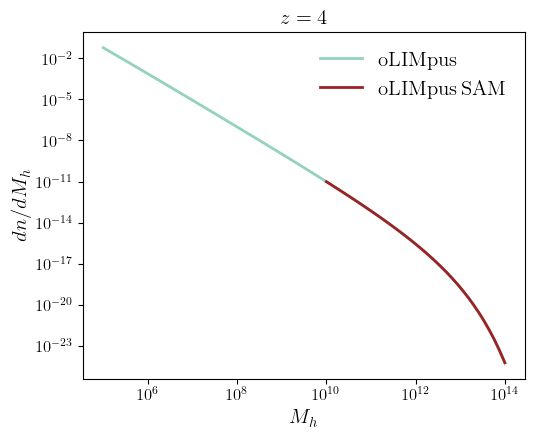

In [10]:
plt.loglog(HMFcl_fid.Mhtab, dndM_oLIMpus,label=r'$\rm oLIMpus$',color=a.colors[3])
plt.loglog(HMFcl_SAM.Mhtab, dndM_oLIMpus_SAM,label=r'$\rm oLIMpus\,SAM$',color=a.colors[-1],ls='-')
plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$dn/dM_h$')
#plt.ylim(1e-20,1e-1)

In [11]:
marr, zarr = np.meshgrid(HMFcl_fid.Mhtab,HMFcl_fid.zHMFtab)
marr_SAM, zarr_SAM = np.meshgrid(HMFcl_SAM.Mhtab,HMFcl_SAM.zHMFtab)
sfr_oLIMpus = SFR_II(AP_fid,CP_fid,HMFcl_fid,marr, zarr, zarr)
sfr_oLIMpus_SAM = SFR_II(AP_fid,CP_SAM,HMFcl_SAM,marr_SAM, zarr_SAM, zarr_SAM)
sfr_oLIMpus_interp = RegularGridInterpolator((HMFcl_fid.Mhtab,HMFcl_fid.zHMFtab),sfr_oLIMpus.T)
sfr_oLIMpus_interp_SAM = RegularGridInterpolator((HMFcl_SAM.Mhtab,HMFcl_SAM.zHMFtab),sfr_oLIMpus_SAM.T)

(100000000.0, 10000000000000.0)

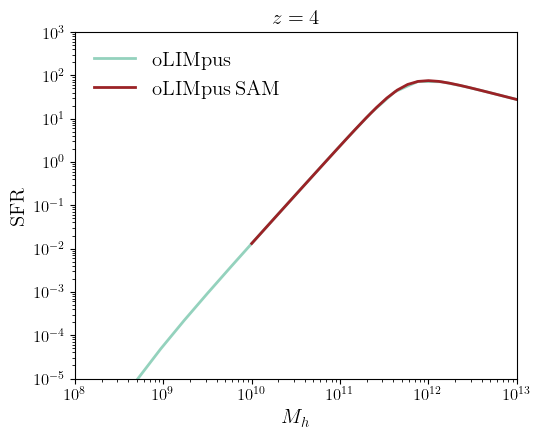

In [12]:
plt.loglog(HMFcl_fid.Mhtab,sfr_oLIMpus_interp((HMFcl_fid.Mhtab,z)),label=r'$\rm oLIMpus$',color=a.colors[3])
plt.loglog(HMFcl_SAM.Mhtab,sfr_oLIMpus_interp_SAM((HMFcl_SAM.Mhtab,z)),label=r'$\rm oLIMpus\,SAM$',color=a.colors[-1],ls='-')
plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\rm SFR$')
plt.ylim(1e-5,1e3)
plt.xlim(1e8,1e13)

In [13]:
zLIM_longer = np.geomspace(ZMIN, 50, 128) #extend to z = 50 for extrapolation purposes
zLIM, mArray_LIM = np.meshgrid(zLIM_longer, HMFcl_fid.Mhtab, indexing = 'ij', sparse = True)
zSAM, mArray_SAM = np.meshgrid(zLIM_longer, HMFcl_SAM.Mhtab, indexing = 'ij', sparse = True)

rhoLSFR = RegularGridInterpolator((zLIM_longer,HMFcl_fid.Mhtab),rhoL_integrand(False, LP_SFR, AP_fid, CP_fid, HMFcl_fid, mArray_LIM, zLIM)/mArray_LIM)
rhoSFR_scatter = RegularGridInterpolator((zLIM_longer,HMFcl_fid.Mhtab),rhoL_integrand(False, LP_SFR_scatter, AP_fid, CP_fid, HMFcl_fid, mArray_LIM, zLIM)/mArray_LIM)
rhoSFR_SAM = RegularGridInterpolator((zLIM_longer,HMFcl_SAM.Mhtab),rhoL_integrand(False, LP_SFR, AP_fid, CP_SAM, HMFcl_SAM, mArray_SAM, zSAM)/mArray_SAM)
rhoSFR_SAM_scatter = RegularGridInterpolator((zLIM_longer,HMFcl_SAM.Mhtab),rhoL_integrand(False, LP_SFR_scatter, AP_fid, CP_SAM, HMFcl_SAM, mArray_SAM, zSAM)/mArray_SAM)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:8: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L)


(1e-50, 10.0)

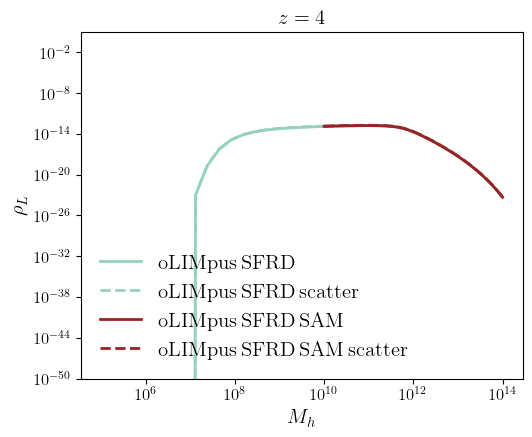

In [14]:
plt.loglog(HMFcl_fid.Mhtab,rhoLSFR((z,HMFcl_fid.Mhtab)),label=r'$\rm oLIMpus\,SFRD$',color=a.colors[3])
plt.loglog(HMFcl_fid.Mhtab,rhoSFR_scatter((z,HMFcl_fid.Mhtab)),label=r'$\rm oLIMpus\,SFRD\,scatter$',color=a.colors[3],ls='--')
plt.loglog(HMFcl_SAM.Mhtab,rhoSFR_SAM((z,HMFcl_SAM.Mhtab)),label=r'$\rm oLIMpus\,SFRD\,SAM$',color=a.colors[-1],ls='-')
plt.loglog(HMFcl_SAM.Mhtab,rhoSFR_SAM_scatter((z,HMFcl_SAM.Mhtab)),label=r'$\rm oLIMpus\,SFRD\,SAM\,scatter$',color=a.colors[-1],ls='--')

plt.legend()
plt.title(r'$z=%g$'%z)
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\rho_L$')
plt.ylim(1e-50,1e1)

In [15]:
SFRDmean_oLIMpus = interp1d(LIM_coeff_SFR.zintegral,LIM_coeff_SFR.rhoL_avg)
SFRDmean_oLIMpus_scatter = interp1d(LIM_coeff_SFR_scatter.zintegral,LIM_coeff_SFR_scatter.rhoL_avg)
SFRDmean_oLIMpus_SAM = interp1d(LIM_coeff_SFR_SAM.zintegral,LIM_coeff_SFR_SAM.rhoL_avg)
SFRDmean_oLIMpus_SAM_scatter = interp1d(LIM_coeff_SFR_SAM_scatter.zintegral,LIM_coeff_SFR_SAM_scatter.rhoL_avg)

In [16]:
print('oLIMpus mean observed SFRD mean = ' + str(SFRDmean_oLIMpus(z)))
print('oLIMpus mean observed SFRD mean with scatter = ' + str(SFRDmean_oLIMpus_scatter(z)))
print('oLIMpus mean observed SFRD mean SAM = ' + str(SFRDmean_oLIMpus_SAM(z)))
print('oLIMpus mean observed SFRD mean SAM with scatter = ' + str(SFRDmean_oLIMpus_SAM_scatter(z)))

oLIMpus mean observed SFRD mean = 0.10023278987139667
oLIMpus mean observed SFRD mean with scatter = 0.11120265882342628
oLIMpus mean observed SFRD mean SAM = 0.0992354119143689
oLIMpus mean observed SFRD mean SAM with scatter = 0.11009464146531955


In [17]:
pk_oLIMpus_SFR = RegularGridInterpolator((LIM_coeff_SFR.zintegral,LIM_pk_SFR.klist_PS),LIM_pk_SFR._Pk_LIM_tot)
pk_shot_oLIMpus_SFR = RegularGridInterpolator((LIM_coeff_SFR.zintegral,LIM_pk_SFR.klist_PS),LIM_pk_SFR.P_shot_noise)

pk_oLIMpus_SFR_scatter = RegularGridInterpolator((LIM_coeff_SFR_scatter.zintegral,LIM_pk_SFR_scatter.klist_PS),LIM_pk_SFR_scatter._Pk_LIM_tot)
pk_shot_oLIMpus_SFR_scatter = RegularGridInterpolator((LIM_coeff_SFR_scatter.zintegral,LIM_pk_SFR_scatter.klist_PS),LIM_pk_SFR_scatter.P_shot_noise)

pk_oLIMpus_SFR_SAM = RegularGridInterpolator((LIM_coeff_SFR_SAM.zintegral,LIM_pk_SFR_SAM.klist_PS),LIM_pk_SFR_SAM._Pk_LIM_tot)
pk_shot_oLIMpus_SFR_SAM = RegularGridInterpolator((LIM_coeff_SFR_SAM.zintegral,LIM_pk_SFR_SAM.klist_PS),LIM_pk_SFR_SAM.P_shot_noise)

pk_oLIMpus_SFR_SAM_scatter = RegularGridInterpolator((LIM_coeff_SFR_SAM_scatter.zintegral,LIM_pk_SFR_SAM_scatter.klist_PS),LIM_pk_SFR_SAM_scatter._Pk_LIM_tot)
pk_shot_oLIMpus_SFR_SAM_scatter = RegularGridInterpolator((LIM_coeff_SFR_SAM_scatter.zintegral,LIM_pk_SFR_SAM_scatter.klist_PS),LIM_pk_SFR_SAM_scatter.P_shot_noise)

Text(0, 0.5, '$P_{\\rm 2h+shot}(k)$')

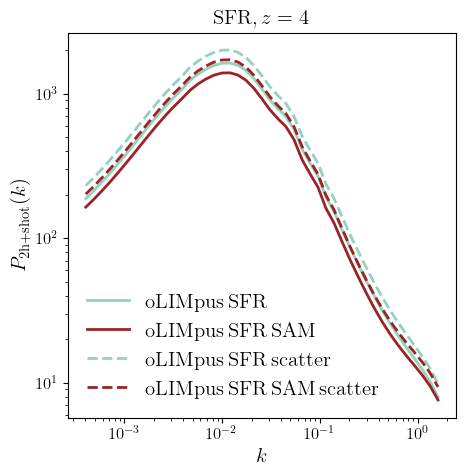

In [23]:
plt.figure(figsize=(5,5))
plt.title(r'$\rm SFR,\,$'+r'$z=%g$'%z)
plt.loglog(LIM_pk_SFR.klist_PS,pk_oLIMpus_SFR((z,LIM_pk_SFR.klist_PS)),label=r'$\rm oLIMpus\,SFR$',color=a.colors[3],ls='-')
plt.loglog(LIM_pk_SFR_SAM.klist_PS,pk_oLIMpus_SFR_SAM((z,LIM_pk_SFR_SAM.klist_PS)),label=r'$\rm oLIMpus\,SFR\,SAM$',color=a.colors[-1],ls='-')
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$P_{\rm 2h+shot}(k)$')

plt.loglog(LIM_pk_SFR_scatter.klist_PS,pk_oLIMpus_SFR_scatter((z,LIM_pk_SFR_scatter.klist_PS)),label=r'$\rm oLIMpus\,SFR\,scatter$',color=a.colors[3],ls='--')
plt.loglog(LIM_pk_SFR_SAM_scatter.klist_PS,pk_oLIMpus_SFR_SAM_scatter((z,LIM_pk_SFR_SAM_scatter.klist_PS)),label=r'$\rm oLIMpus\,SFR\,SAM\,scatter$',color=a.colors[-1],ls='--')
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$P_{\rm 2h+shot}(k)$')

### Create maps

To get the LIM coeval box we use the maps_LIM.py module.

In [19]:
# properties to compute the coeval boxes
zbox = z
Lbox = 200
Nbox = 50
seed = 333

LIM_boxes_SFR = CoevalBox_LIM_analytical(LIM_coeff_SFR,
                                     LIM_corr_SFR,
                                     LIM_pk_SFR,
                                     LP_SFR,
                                     zbox,
                                     LP_SFR._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=True,
                                     seed=seed)

LIM_boxes_SFR_scatter = CoevalBox_LIM_analytical(LIM_coeff_SFR_scatter,
                                     LIM_corr_SFR_scatter,
                                     LIM_pk_SFR_scatter,
                                     LP_SFR_scatter,
                                     zbox,
                                     LP_SFR_scatter._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=True,
                                     seed=seed)

LIM_boxes_SFR_SAM = CoevalBox_LIM_analytical(LIM_coeff_SFR_SAM,
                                     LIM_corr_SFR_SAM,
                                     LIM_pk_SFR_SAM,
                                     LP_SFR,
                                     zbox,
                                     LP_SFR._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=True,
                                     seed=seed)

LIM_boxes_SFR_SAM_scatter = CoevalBox_LIM_analytical(LIM_coeff_SFR_SAM_scatter,
                                     LIM_corr_SFR_SAM_scatter,
                                     LIM_pk_SFR_SAM_scatter,
                                     LP_SFR_scatter,
                                     zbox,
                                     LP_SFR_scatter._R,
                                     Lbox=Lbox,
                                     Nbox=Nbox, 
                                     RSD=RSD_MODE, 
                                     get_density_box=True,
                                     seed=seed)


/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/powerbox/powerbox.py:396: RuntimeWarning: invalid value encountered in log
  return np.log(1 + self.correlation_array())


## NO SMOOTHING

In [20]:
# line 
box_SFR = LIM_boxes_SFR.Inu_box
# line without shot noise
box_SFR_noSN = LIM_boxes_SFR.Inu_box_noiseless
# line 
box_SFR_scatter = LIM_boxes_SFR_scatter.Inu_box
# line without shot noise
box_SFR_scatter_noSN = LIM_boxes_SFR_scatter.Inu_box_noiseless

# line 
box_SFR_SAM = LIM_boxes_SFR_SAM.Inu_box
# line without shot noise
box_SFR_SAM_noSN = LIM_boxes_SFR_SAM.Inu_box_noiseless
# line 
box_SFR_SAM_scatter = LIM_boxes_SFR_SAM_scatter.Inu_box
# line without shot noise
box_SFR_SAM_scatter_noSN = LIM_boxes_SFR_SAM_scatter.Inu_box_noiseless

Let's plot them.

Text(0.05, 0.05, '${\\rm SFRD}\\,SAM\\,scatter\\,[{\\rm M_*/yr/Mpc^3}]$')

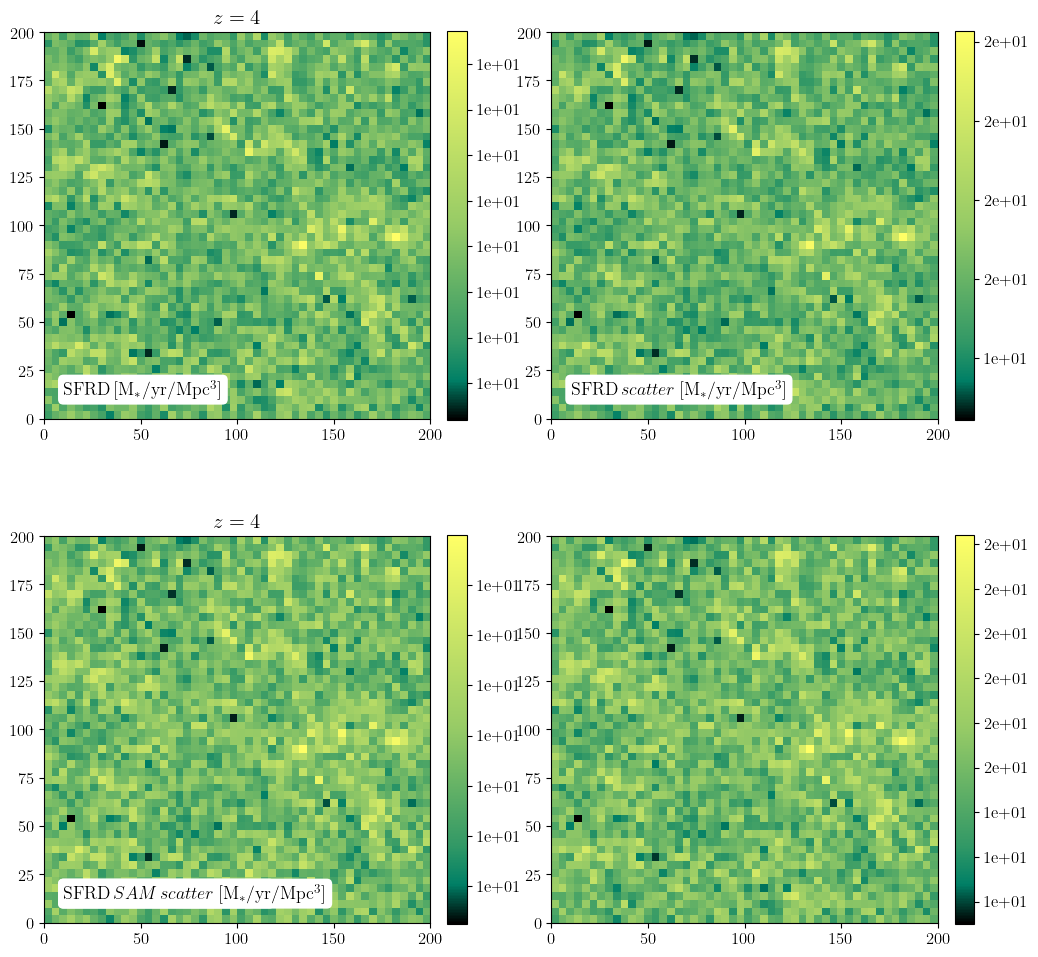

In [21]:
_islice = 0 # which slice

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# SFR 
im = ax[0,0].imshow(box_SFR[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[0,0], fraction=0.046, pad=0.04, format="%.0e")

ax[0,0].text(
    0.05, 0.05, r'${\rm SFRD}\,[{\rm M_*/yr/Mpc^3}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0,0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[0,0].set_title(r'$z=%g$'%zbox)

im = ax[0,1].imshow(box_SFR_scatter[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04, format="%.0e")

ax[0,1].text(
    0.05, 0.05, r'${\rm SFRD}\,scatter\,[{\rm M_*/yr/Mpc^3}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[0,1].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

# SFR 
im = ax[1,0].imshow(box_SFR_SAM[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[1,0], fraction=0.046, pad=0.04, format="%.0e")

ax[1,0].text(
    0.05, 0.05, r'${\rm SFRD}\,SAM\,[{\rm M_*/yr/Mpc^3}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1,0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)

ax[1,0].set_title(r'$z=%g$'%zbox)

im = ax[1,1].imshow(box_SFR_SAM_scatter[_islice], extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
fig.colorbar(im, ax=ax[1,1], fraction=0.046, pad=0.04, format="%.0e")

ax[1,1].text(
    0.05, 0.05, r'${\rm SFRD}\,SAM\,scatter\,[{\rm M_*/yr/Mpc^3}]$', 
    color='black',
    fontsize=13,
    ha='left', va='bottom',
    transform=ax[1,0].transAxes,  
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
)



Finally, let's have a look at the theoretical LIM power spectrum, compared with the power spectra measured from the boxes.

(0.5, 3000.0)

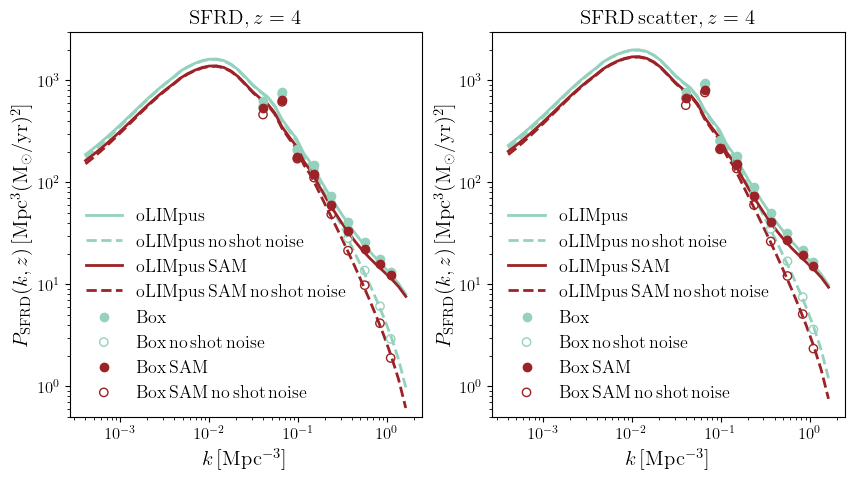

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),)

# LIM
# theory power spectrum
klist = LIM_corr_SFR_SAM._klistCF
iz_val = min(range(len(LIM_coeff_SFR.zintegral)), key=lambda i: np.abs((LIM_coeff_SFR.zintegral[i]-zbox))) # which z 

Pk_analytical = LIM_pk_SFR._Pk_LIM_tot 
Pk_analytical_noSN = LIM_pk_SFR._Pk_LIM_RSD

Pk_analytical_scatter = LIM_pk_SFR_scatter._Pk_LIM_tot 
Pk_analytical_noSN_scatter = LIM_pk_SFR_scatter._Pk_LIM_RSD

Pk_analytical_SAM = LIM_pk_SFR_SAM._Pk_LIM_tot 
Pk_analytical_SAM_noSN = LIM_pk_SFR_SAM._Pk_LIM_RSD

Pk_analytical_SAM_scatter = LIM_pk_SFR_SAM_scatter._Pk_LIM_tot 
Pk_analytical_SAM_noSN_scatter = LIM_pk_SFR_SAM_scatter._Pk_LIM_RSD

# from the boxes
k_bins = np.logspace(np.log10(2*np.pi/Lbox),np.log10(2*np.pi/Lbox*Nbox),10) # define the k array 

pk_SFR, k_SFR = pb.get_power(
    deltax = box_SFR,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_noSN, _ = pb.get_power(
    deltax = box_SFR_noSN,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_scatter, k_SFR_scatter = pb.get_power(
    deltax = box_SFR_scatter,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_noSN_scatter, _ = pb.get_power(
    deltax = box_SFR_scatter_noSN,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_SAM, _ = pb.get_power(
    deltax = box_SFR_SAM,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_SAM_noSN, _ = pb.get_power(
    deltax = box_SFR_SAM_noSN,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_SAM_scatter, k_SFR_scatter = pb.get_power(
    deltax = box_SFR_SAM_scatter,
    boxlength= Lbox,
    bins = k_bins,
    ) 

pk_SFR_SAM_noSN_scatter, _ = pb.get_power(
    deltax = box_SFR_SAM_scatter_noSN,
    boxlength= Lbox,
    bins = k_bins,
    ) 

axes[0].loglog(klist,Pk_analytical[iz_val],color=a.colors[3],label=r'${\rm oLIMpus}$')
axes[0].loglog(klist,Pk_analytical_noSN[iz_val],color=a.colors[3],label=r'${\rm oLIMpus\,no\,shot\,noise}$',ls='--')

axes[0].loglog(klist,Pk_analytical_SAM[iz_val],color=a.colors[-1],label=r'${\rm oLIMpus\,SAM}$')
axes[0].loglog(klist,Pk_analytical_SAM_noSN[iz_val],color=a.colors[-1],label=r'${\rm oLIMpus\,SAM\,no\,shot\,noise}$',ls='--')

axes[0].scatter(k_SFR,pk_SFR,color=a.colors[3],marker='o',zorder=8,label=r'$\rm Box$')
axes[0].scatter(k_SFR,pk_SFR_noSN,color=a.colors[3],marker='o',zorder=8,label=r'$\rm Box\,no\,shot\,noise$',facecolor='none')

axes[0].scatter(k_SFR,pk_SFR_SAM,color=a.colors[-1],marker='o',zorder=8,label=r'$\rm Box\,SAM$')
axes[0].scatter(k_SFR,pk_SFR_SAM_noSN,color=a.colors[-1],marker='o',zorder=8,label=r'$\rm Box\,SAM\,no\,shot\,noise$',facecolor='none')

axes[0].set_ylabel(r'${P_{\rm SFRD}(k,z)}\,[\rm Mpc^{3}(M_\odot/yr)^2]$',fontsize=15)
axes[0].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[0].legend(fontsize=13,columnspacing=0.5,loc=3,ncol=1)
axes[0].set_title(r'${\rm SFRD}, z=%g$'%zbox)
axes[0].set_ylim(5e-1,3e3)

axes[1].loglog(klist,Pk_analytical_scatter[iz_val],color=a.colors[3],label=r'${\rm oLIMpus}$')
axes[1].loglog(klist,Pk_analytical_noSN_scatter[iz_val],color=a.colors[3],label=r'${\rm oLIMpus\,no\,shot\,noise}$',ls='--')

axes[1].loglog(klist,Pk_analytical_SAM_scatter[iz_val],color=a.colors[-1],label=r'${\rm oLIMpus\,SAM}$')
axes[1].loglog(klist,Pk_analytical_SAM_noSN_scatter[iz_val],color=a.colors[-1],label=r'${\rm oLIMpus\,SAM\,no\,shot\,noise}$',ls='--')

axes[1].scatter(k_SFR,pk_SFR_scatter,color=a.colors[3],marker='o',zorder=8,label=r'$\rm Box$')
axes[1].scatter(k_SFR,pk_SFR_noSN_scatter,color=a.colors[3],marker='o',zorder=8,label=r'$\rm Box\,no\,shot\,noise$',facecolor='none')

axes[1].scatter(k_SFR,pk_SFR_SAM_scatter,color=a.colors[-1],marker='o',zorder=8,label=r'$\rm Box\,SAM$')
axes[1].scatter(k_SFR,pk_SFR_SAM_noSN_scatter,color=a.colors[-1],marker='o',zorder=8,label=r'$\rm Box\,SAM\,no\,shot\,noise$',facecolor='none')

axes[1].set_ylabel(r'${P_{\rm SFRD}(k,z)}\,[\rm Mpc^{3}(M_\odot/yr)^2]$',fontsize=15)
axes[1].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[1].legend(fontsize=13,columnspacing=0.5,loc=3,ncol=1)
axes[1].set_title(r'${\rm SFRD\,scatter}, z=%g$'%zbox)
axes[1].set_ylim(5e-1,3e3)

